# **An Overview On Speech Recognition**

---
---

* **What is speech recognition?**
> Speech recognition, also known as Automatic Speech Recognition (ASR) is the process of converting spoken language into set of words. 

* **How does it work?**
> There are some algorithms for speech recognition.
> * Hidden markov models (HMM)
> * N-grams
> * Artificial neural networks
> * Speaker Diarization (SD)

But *Hidden Markov Model* and *Artificial Neural Network* are mostly used in speech recognition.

In [ ]:
import os
import pathlib
from IPython import display

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import librosa

# **Problem Statement**

For this problem we used Google's *Mini Speech Commands dataset*. This dataset contains 8000 audio files of 8 different speech commands (up, yes, left, down, no, go, stop, right) of 1 second duration. Our task is to recognize these 8 different commands.<br><br><br>

---
**For solving the problem we used artificial neural network, and for input of the network we converted the time domain signal into spectrogram by short time fourier transform. In case of output the network would give probability of each commands.**

# **Artificial Neural Network**
An artificial neural network is an interconnected group of nodes, inspired by a simplification of neurons in a brain. <br>
ANN consist of an input layer, one or more hidden layers, and an output layer. 
<br><br>
**Input layer**: Input layer is the first layer of a neural network. It takes data from the user and pass it to next hidden layer. Input data can be list of numbers, images, audio, or video.

**Hidden layer**: All of the layers between input and output layers are called *hidden layers*. All of the calculations take place in here. 

**Output layer**: The last type of layer is the output layer. The output layer holds the result or the output of the problem.
<br>
.
.
.

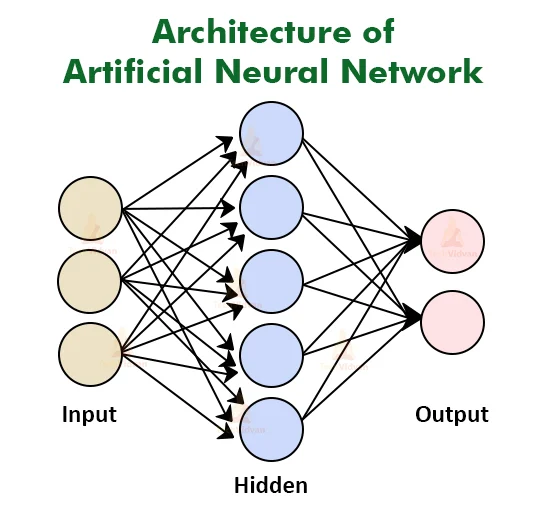

# Loading Data

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    keras.utils.get_file(
      'mini_speech_commands.zip',
      origin= "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract= True,
      cache_dir= '.', cache_subdir= 'data'
    )

In [ ]:
commands = np.array(os.listdir(data_dir))
commands = commands[commands != 'README.md']
print(commands)

['up' 'yes' 'left' 'down' 'no' 'go' 'stop' 'right']


# Preprocessing and Normalizing The Data

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)

'''
train data size 6400
validation data size 800
test data size 800
'''
train_files = filenames[:6400]
val_files = filenames[6400:6400+800]
test_files = filenames[-800:]

# Reading file name (bytes fomat)

train_files = train_files[:].numpy()
val_files = val_files[:].numpy()
test_files = test_files[:].numpy()

# Converting bytes into string

for i in range(train_files.size):
    train_files[i] = train_files[i].decode('utf-8')
    if i < val_files.size: val_files[i] = val_files[i].decode('utf-8')
    if i < test_files.size: test_files[i] = test_files[i].decode('utf-8')

In [ ]:
def get_label(file_path):
    pre = DATASET_PATH + '/'
    f = file_path[len(pre):]
    f = f.partition('/')[0]
    return f

# Read a audio file and returns a tensor of that audio. -1 <= amplitude <=1
def read_file(file_path):
    raw_audio = tf.io.read_file(file_path)
    audio, sr = tf.audio.decode_wav(raw_audio)
    return tf.squeeze(audio.numpy())


In [ ]:
X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []

for i in range(train_files.size):
    X_train.append(read_file(train_files[i]))
    y_train.append(get_label(train_files[i]))

    if i < 800:
        X_val.append(read_file(val_files[i]))
        y_val.append(get_label(val_files[i]))

        X_test.append(read_file(test_files[i]))
        y_test.append(get_label(test_files[i]))

X_train = np.array(X_train, dtype= object)
y_train = np.array(y_train)

X_val = np.array(X_val, dtype= object)
y_val = np.array(y_val)

X_test = np.array(X_test, dtype= object)
y_test = np.array(y_test)

# Ploting some random audio from train set

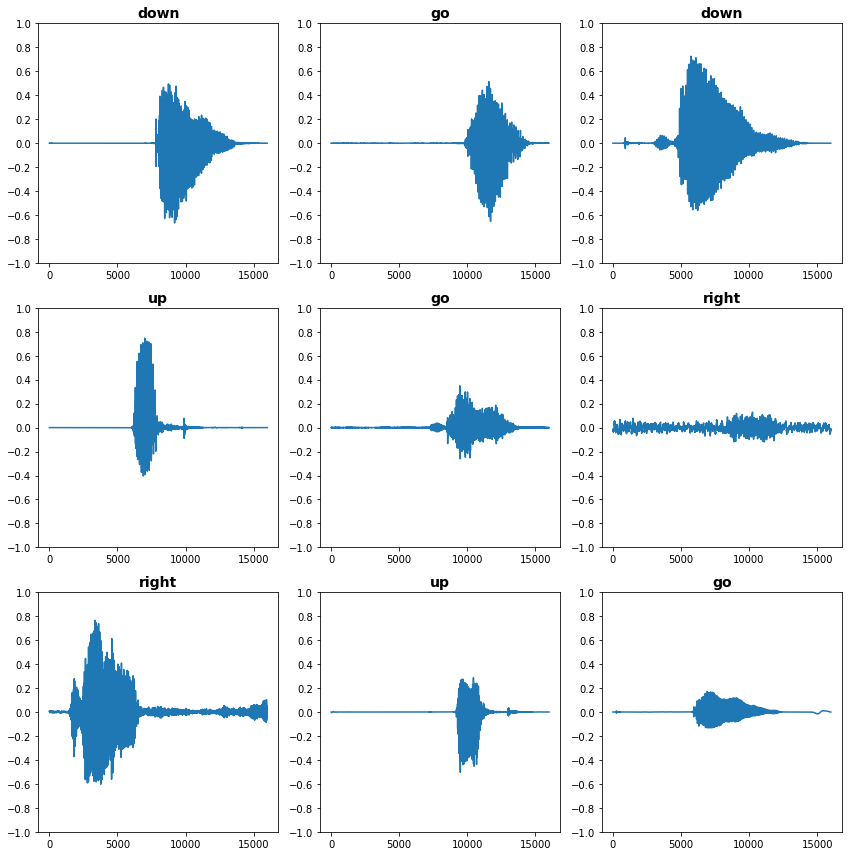

In [ ]:
indx = np.random.randint(0, 6400, 9)
time = np.linspace(0, 1, 16000)
fig, ax = plt.subplots(3, 3, figsize= (12, 12))

for i in range(len(indx)):
    file = train_files[i]
    label = get_label(file)
    signal = read_file(file)
    plt.tight_layout()
    axx = ax[i//3, i%3]
    axx.plot(signal)
    axx.set_yticks(np.arange(-1, 1.1, .2 ))
    axx.set_title(label, {'fontweight': 'bold', 'size': 14})

plt.show()

# Spectrogram

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. A spectrogram is usually depicted as a heat map. The intensity of a signal shown by varying color or by brightness.<br>
*X* axis of a spectrogram represents time, *Y* axis represents frequency and the brightness of a color represents the amplitude of the signal at a particular time and frequency.
<br><br>
To generate a spectrogram, a time-domain signal is divided into shorter segments of equal length. Then, the fast Fourier transform (FFT) is applied to each segment. The spectrogram is a plot of the spectrum on each segment. The frame count parameter determines the number of FFTs used to create the spectrogram and, as a result, the amount of the overall time signal that is split into independent FFTs.<br>
This variant of fourier transform is also called *Short Time Fourier Transform*.

In [ ]:
def get_spectrogram(audio):
    zero_padding = tf.zeros([16000] - tf.shape(audio), dtype= tf.float32)
    equal_length = tf.concat([audio, zero_padding], axis= 0)
    spec = tf.signal.stft(
        equal_length,
        frame_length= 255,
        frame_step= 128,
    )
    # returning absolute value of complex matrix
    spec = tf.abs(spec)
    return spec.numpy()

def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    x = np.linspace(0, 1, 124)
    y = np.arange(height)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Log scale)')
    ax.pcolormesh(x, y, log_spec,)


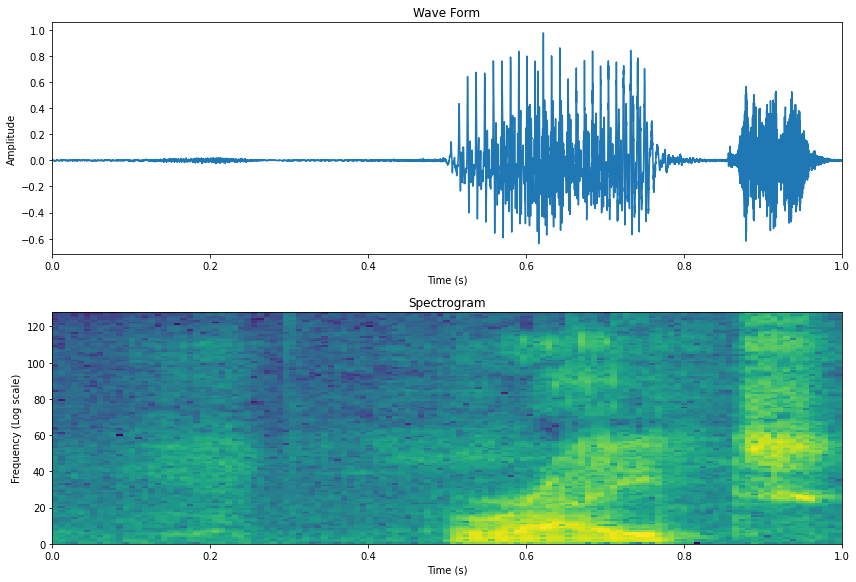

In [ ]:
spec = get_spectrogram(X_val[0])

fig, ax = plt.subplots(2, figsize= (12, 8))

ax[0].set_title('Wave Form')
plt.tight_layout()
ax[0].plot(time, X_val[0])
ax[0].set_xlim([0, 1])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')

ax[1].set_title('Spectrogram')
plt.tight_layout()
plot_spectrogram(spec, ax[1])


plt.show()
display.Audio(val_files[0])

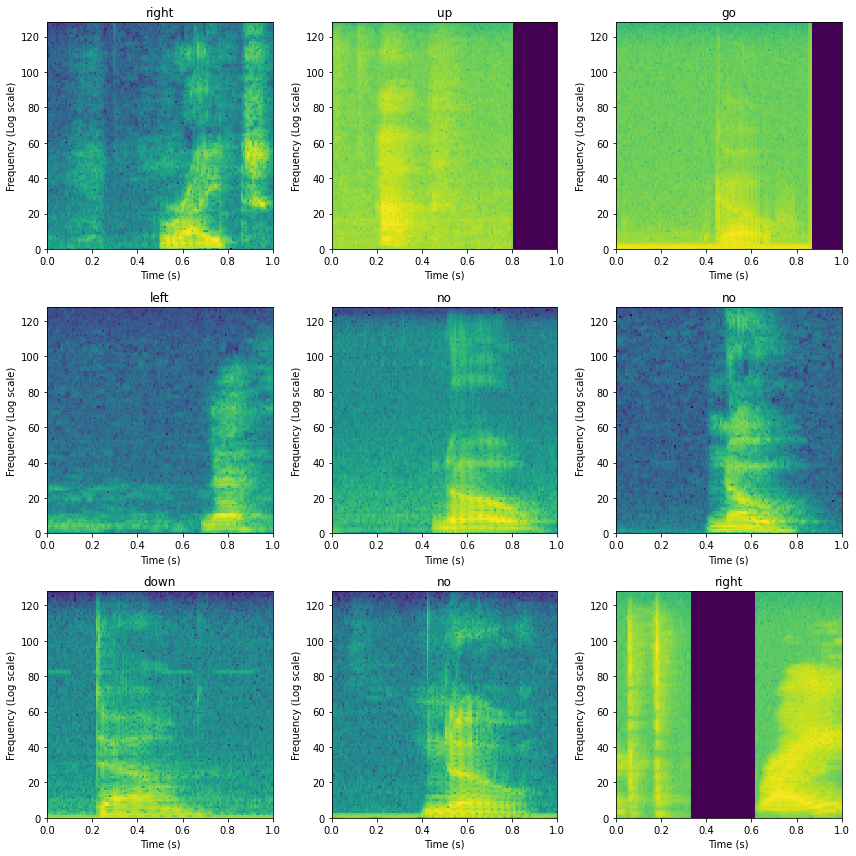

In [ ]:
fig, ax = plt.subplots(3, 3, figsize= (12, 12))

for i in range(len(indx)):
    axx = ax[i//3, i%3]
    spec = get_spectrogram(X_val[i])
    plt.tight_layout()
    plot_spectrogram(spec, axx)
    axx.set_title(y_val[i])
plt.show()

In [ ]:
# Converting commnands list into dictionary
command_dc = {ele: indx for indx, ele in enumerate(commands)}

# Converting string label into integer label
Y_train = np.array([command_dc[ele] for ele in y_train])
Y_val = np.array([command_dc[ele] for ele in y_val])
Y_test = np.array([command_dc[ele] for ele in y_test])


In [ ]:
X_train_spec = np.array([get_spectrogram(x) for x in X_train])
X_val_spec = np.array([get_spectrogram(x) for x in X_val])
X_test_spec = np.array([get_spectrogram(x) for x in X_test])

# Creating Model

We used three 2D convolutional layers and two dense layers to create the neural network model.

In [ ]:
# One Hot
Y_train = keras.utils.to_categorical(Y_train, len(commands))
Y_val = keras.utils.to_categorical(Y_val, len(commands))
Y_test = keras.utils.to_categorical(Y_test, len(commands))


In [ ]:
XX = X_train_spec
XX = XX.reshape((XX.shape[0], XX.shape[1], XX.shape[2], 1))
INPUT_SHAPE = XX.shape[1:]

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (3, 3), input_shape= INPUT_SHAPE, activation= 'selu', kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides= (2, 2), padding= 'same'),

    keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides= (2, 2), padding= 'same'),

    keras.layers.Conv2D(32, (3, 3), activation= 'relu', kernel_regularizer= keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D((2, 2), strides= (2, 2), padding= 'same'),

    keras.layers.Flatten(),
    keras.layers.Dense(64, activation= 'selu'),
    keras.layers.Dense(32, activation= 'relu'),

    keras.layers.Dense(8, activation= 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 122, 127, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 62, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 59, 62, 32)       128       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(), loss= keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])


In [ ]:
history = model.fit(
    XX, Y_train, 
    epochs= 20, 
    validation_data= (X_val_spec, Y_val),
)

Epoch 1/20
200/200 [==============================] - 18s 29ms/step - loss: 1.5434 - accuracy: 0.4716 - val_loss: 2.8011 - val_accuracy: 0.2400
Epoch 2/20
200/200 [==============================] - 5s 27ms/step - loss: 0.7998 - accuracy: 0.7241 - val_loss: 1.4501 - val_accuracy: 0.5813
Epoch 3/20
200/200 [==============================] - 5s 27ms/step - loss: 0.4983 - accuracy: 0.8450 - val_loss: 0.9049 - val_accuracy: 0.7625
Epoch 4/20
200/200 [==============================] - 5s 27ms/step - loss: 0.3403 - accuracy: 0.9077 - val_loss: 0.7951 - val_accuracy: 0.7638
Epoch 5/20
200/200 [==============================] - 5s 27ms/step - loss: 0.2476 - accuracy: 0.9420 - val_loss: 0.6586 - val_accuracy: 0.8325
Epoch 6/20
200/200 [==============================] - 5s 27ms/step - loss: 0.2000 - accuracy: 0.9575 - val_loss: 0.7149 - val_accuracy: 0.8150
Epoch 7/20
200/200 [==============================] - 5s 27ms/step - loss: 0.2214 - accuracy: 0.9494 - val_loss: 0.9866 - val_accuracy: 0.802

In [ ]:
model.evaluate(X_test_spec, Y_test)

25/25 [==============================] - 0s 11ms/step - loss: 0.5554 - accuracy: 0.8900


[0.5554197430610657, 0.8899999856948853]

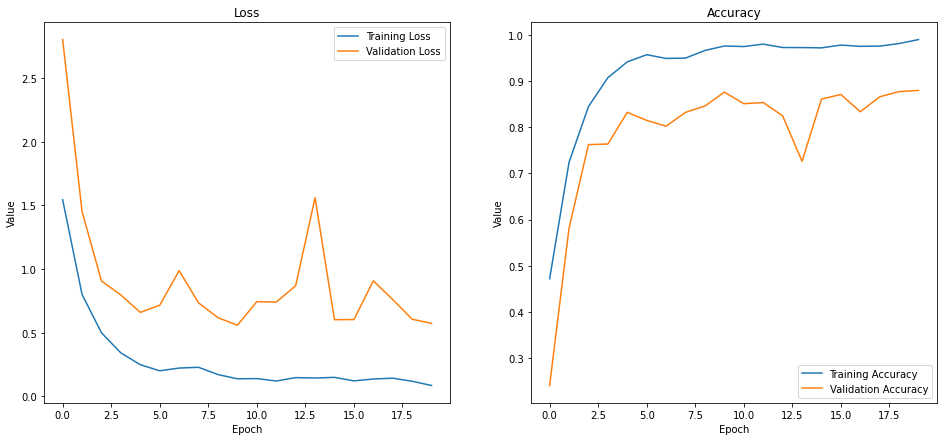

In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize= (16, 7))
plt.subplot(1, 2, 1)
plt.plot(loss, label= 'Training Loss')
plt.plot(val_loss, label= 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label= 'Training Accuracy')
plt.plot(val_accuracy, label= 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.legend()
plt.show()

# Testing Model


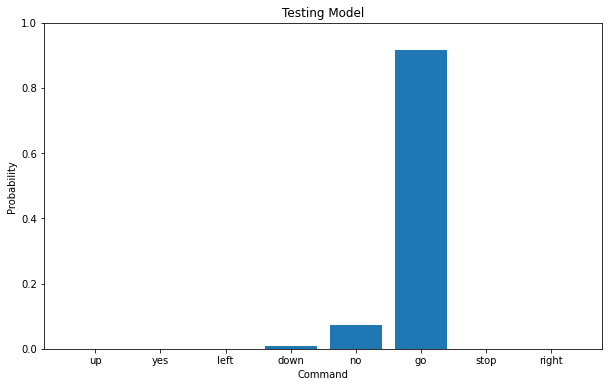

In [ ]:
indx = 0

predict = model.predict(tf.constant([X_test_spec[indx]]))
predict = tf.squeeze(predict)
plt.figure(figsize= (10, 6))
plt.bar(commands, predict)
plt.title('Testing Model')
plt.xlabel('Command')
plt.ylabel('Probability')
plt.yticks(np.arange(0, 1.01, .2))
plt.show()

display.Audio(test_files[indx])